In [1]:
from time import perf_counter_ns

import numpy as np
import matplotlib.pyplot as plt

from typing import Optional

## Task 1: Playing with Pseudo-Randomness

### Part A: Implement and Benchmark an LCG

In [2]:
def linear_congruential_generator(seed: int,
                                  multipler: int,
                                  increment: int,
                                  modulus: int,
                                  sequence_length: Optional[int] = None):
    sequence = [seed]

    if sequence_length is None:
        sequence_length = modulus

    for i in range(sequence_length):
        sequence.append((sequence[-1] * multipler + increment) % modulus)

    return sequence

In [3]:
LCG_PARAMS = [
    # Multiplier, Increment,   Modulus;
    ([         5,         1,      2**6], True),   # Satisfies Hull-Dobell, small space.
    ([         7,         9,        60], False),  # Does not satisfy Hull-Dobell, small space.
    ([        75,         4, 2**16 + 1], True),   # Satisfies Hull-Dobell, large space.
    ([         7,         1,     30030], False),  # Does not satisfy Hull-Dobell, large space.
    ([         5,         7,     2**10], True),   # Satisfies Hull-Dobell, not a good random space(?)
]
"""
A sequence of the LCG parameters we want to feed in - in the order of
(Multiplier, Increment, Modulus), paired with whether they satisfy the
Hull Dobell Theorem.
"""

'\nA sequence of the LCG parameters we want to feed in - in the order of\n(Multiplier, Increment, Modulus), paired with whether they satisfy the\nHull Dobell Theorem.\n'

In [4]:
# We always use seed as 0 and generate 1M entries.
N_ENTRIES = 10**6
lcg_sequences = [
    linear_congruential_generator(0, *(params[0]), N_ENTRIES) for params in LCG_PARAMS
]


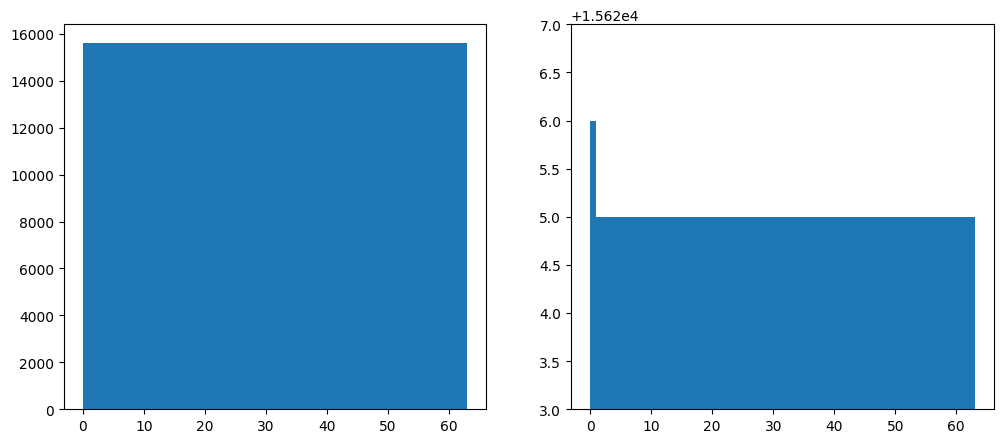

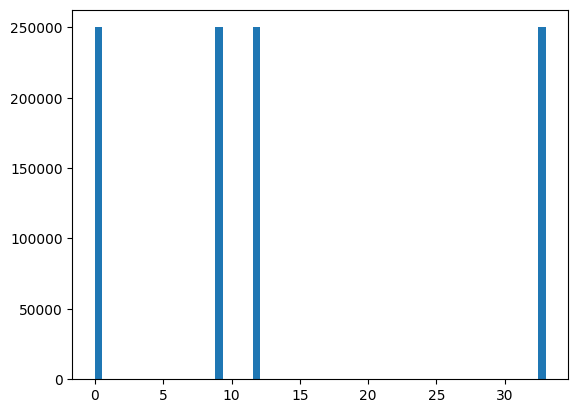

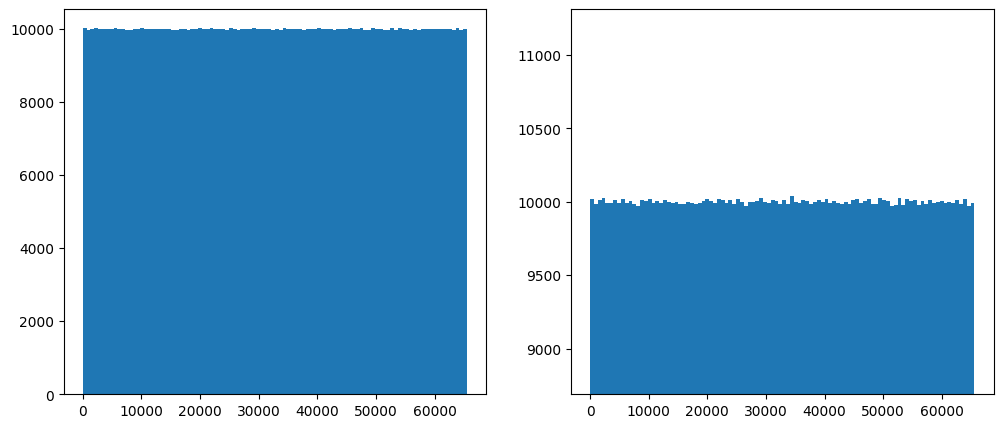

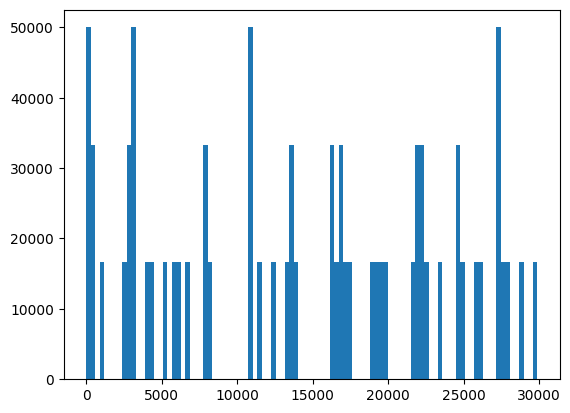

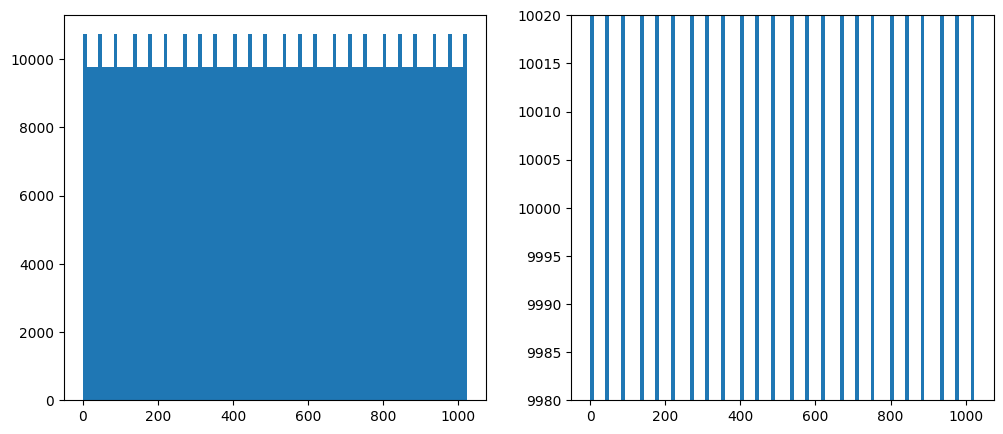

In [22]:
for sequence, params in zip(lcg_sequences, LCG_PARAMS):
    size = params[0][2]
    is_hull_dobell = params[1]
    bin_count = 100 if size > 1000 else size

    if is_hull_dobell:
        # We know that the full sequence will be covered before repeating.
        #
        # But after the first loop, the sequence may enter a smaller loop
        # that only covers a subset of the entire sample space. So basically
        # X_{m+1} need not be X_{0}, and if it is not we enter into a smaller
        # loop.
        #
        # Otherwise, if we cover a full cycle every cycle, then the difference
        # between the counts of two bins cannot exceed the x-range that is
        # covered in one bin. So, to check how good our coverage in later cycles
        # is, we zoom in on the y-axis in these cases.
        plt.figure(figsize=(12, 5))

        expected_occurrences = N_ENTRIES / bin_count
        plt.subplot(1, 2, 1)
        plt.hist(sequence, bins=bin_count)

        plt.subplot(1, 2, 2)
        plt.hist(sequence, bins=bin_count)

        dev = 2 * size // bin_count
        plt.ylim(int(expected_occurrences - dev),
                 int(expected_occurrences + dev))
        plt.show()

    else:
        plt.hist(sequence, bins=bin_count)
        plt.show()



In [6]:
def compute_entropy(rand_array: np.ndarray,
                    elements_to_consider: int,
                    use_shannon: bool = False) -> float:
    """
    Computes the entropy of an array containing the sequential outputs of an
    randomly generated array while only considering the first
    ``elements_to_consider`` elements of the array. Based on the ``use_shannon``
    parameter, this function returns either the Shannon entropy or the Min
    entropy (default).
    """
    rand_array = rand_array[:elements_to_consider]
    random_variable_probabilities = \
        np.unique(rand_array, return_counts=True)[1] / len(rand_array)

    if not use_shannon:
        # Use Min entropy.
        return -np.log2(np.max(random_variable_probabilities))

    return np.sum(random_variable_probabilities * -np.log2(random_variable_probabilities))


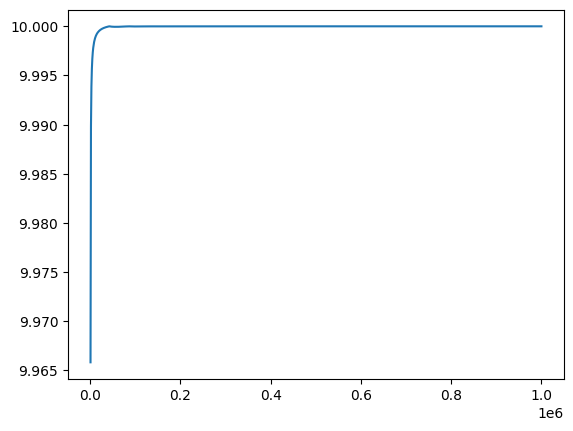

In [7]:
# 1. Choose LCG parameters such that there are no more than 2^10 possible
#    values.
#
# 2. Over a long LCG sequence (at least 10^6 samples), as the generator
#    produces values, treat the sequence of outputs up to each step as a
#    growing empirical distribution.
#
# 3. At regular intervals (e.g., every 1000 iterations), compute the Shannon
#    Entropy or Min-Entropy of the current sample distribution.

def plot_entropy(sequence: np.ndarray, increment: int, use_shannon: bool = False) -> None:
    """
    Plots the entropies of subsequences of the given sequence. The first
    subsequence captures the first ``increment`` elements of the given sequence,
    and each subsequent subsequence captures the next ``increment`` elements of
    the given sequence after the last element covered by its predecessor.

    :param sequence:    The sequence whose step-wise entropy is to be plotted.
    :param increment:   The length of each of the steps.
    :param use_shannon: Whether to use Shannon entropy or the Min entropy (default).
    """
    x_indices = []
    y_indices = []
    for n in range(increment, len(sequence) + 1, increment):
        entropy = compute_entropy(sequence, n, use_shannon=use_shannon)
        x_indices.append(n)
        y_indices.append(entropy)

    plt.plot(x_indices, y_indices)
    plt.show()


INCREMENT = 1000
lcg_output_array = np.array(linear_congruential_generator(seed            = 0,
                                                          multipler       = 5,
                                                          increment       = 1,
                                                          modulus         = 2**10,
                                                          sequence_length = N_ENTRIES))

plot_entropy(lcg_output_array, INCREMENT, use_shannon=True)

### Part B: Implement and Benchmark AES-Based PRNGs

In [8]:
from aes.aes_impl import encrypt_message_aes_cbc

In [9]:
def pad_seed(seed_bytes: bytes, target_len=16) -> bytes:
    """
    A helper function to pad/truncate the given seed to ``target_len`` bytes
    (default 16). Padding is done by adding 0-bytes till we reach the target
    length. Returns the padded seed bytes.
    """
    if len(seed_bytes) > target_len:
        return seed_bytes[:target_len]

    pad_len = target_len - len(seed_bytes)
    return seed_bytes + b'\x00' * pad_len


def aes_pseudo_rng(seed: bytes, num_bytes: int) -> list[bytes]:
    """
    Generates a sequence of pseudo-random bytes using the AES algorithm.

    :param seed: The seed to provide to the AES algorithm.
    :param num_bytes: The number of bytes to generate.

    :return: A list of length-1 byte strings. Each element of this list
             is a pseudo-random byte.
    """
    # One run of the AES generates 16 random bytes, assuming the input length is
    # less than 16 bytes. We will assume that the integers we provide it would
    # be shorter than 16 bytes, since its unlikely that our users will ask for
    # more than 16 * 2^128 bytes to be generated.
    num_iter = num_bytes // 16

    # The AES encryption itself provides the pseudo-randomness, so providing a
    # simple counter is sufficient. Note that this leads to the CTR mode of AES,
    # but we do not use that here.

    # 4 bytes should be enough to cover num_iter, the implementation will pad
    # this ot the needed 16 bytes.
    return [encrypt_message_aes_cbc(i.to_bytes(4), seed)
            for i in range(num_iter)]


In [10]:
SEED_LENGTHS = [1, 2, 8]  # in bytes

# The number of bytes we want to try generating with our AES implementation.
# The original example uses 10^7, but that takes a bit too long while prototyping.
# These values can always be edited later once we're done with everything.
SEQUENCE_LENGTHS = [10 ** 5, 3 * 10**5, 10 ** 6]

In [11]:
# Generate and store sequences. We time this and provide the bitrate.
def generate_aes_sequences(seed_lengths: list[int],
                           sequence_lengths: list[int]) \
        -> tuple[dict[int, dict[int, np.ndarray]], float]:
    """
    Generates and profiles AES-based random sequences for each combination of
    the provided seed lengths and sequence lengths.

    :param seed_lengths: A list of the number of random bytes to provide in each
                         of the seeds used for AES.

    :param sequence_lengths: A list of the lengths of the sequence to generate.

    :return: (A dictionary mapping {seed_length: {sequence_length: array}} where
              array is the array of random (16 byte) integers generated. This
              will have an entry for each combination of seed_lengths and 
              sequence_lengths,
              and,
              The bit_rate - i.e. number of bits generated / second on an average)
    """
    t_start = perf_counter_ns()
    all_sequences = {
        _seed_len: {
            _seq_len: np.array([int.from_bytes(b) for b in
                               aes_pseudo_rng(pad_seed(np.random.bytes(_seed_len)),
                                              _seq_len)])
            for _seq_len in sequence_lengths
        }
        for _seed_len in seed_lengths
    }
    t_elapsed = perf_counter_ns() - t_start
    bit_rate = ((len(seed_lengths) * sum(sequence_lengths) * 8) / t_elapsed) * 10E9
    return all_sequences, bit_rate


ALL_SEQUENCES, BIT_RATE = generate_aes_sequences(SEED_LENGTHS, SEQUENCE_LENGTHS)

print(f"Observed bitrate for AES: {BIT_RATE:.2f} bits/s.")


Observed bitrate for AES: 15655523.76 bits/s.
340281461314790739319058320456980484993


Entropy Plot for seed length 1 and sequence length 100000


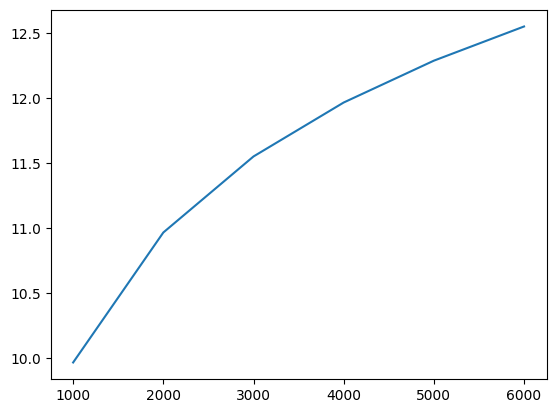

Entropy Plot for seed length 1 and sequence length 300000


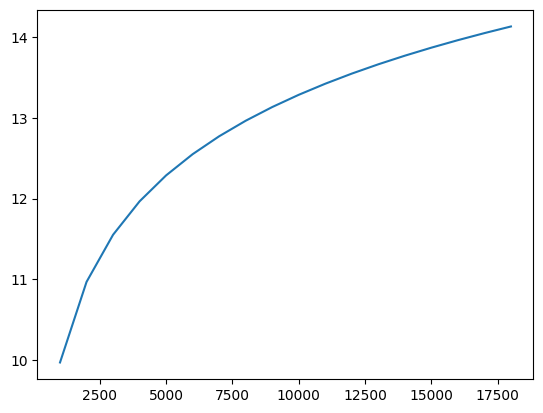

Entropy Plot for seed length 1 and sequence length 1000000


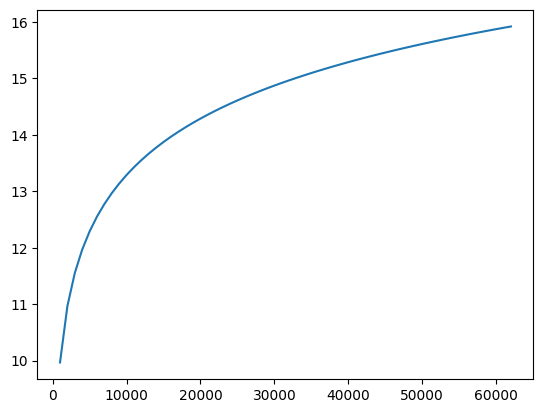

Entropy Plot for seed length 2 and sequence length 100000


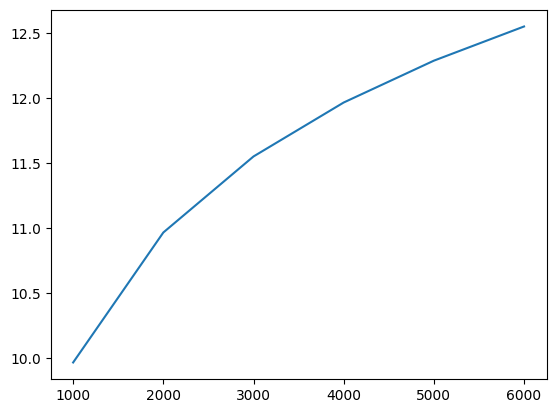

Entropy Plot for seed length 2 and sequence length 300000


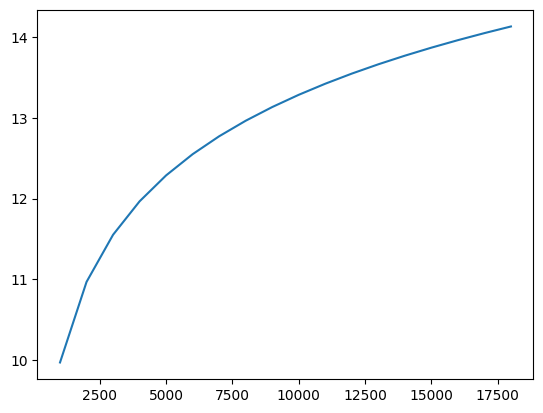

Entropy Plot for seed length 2 and sequence length 1000000


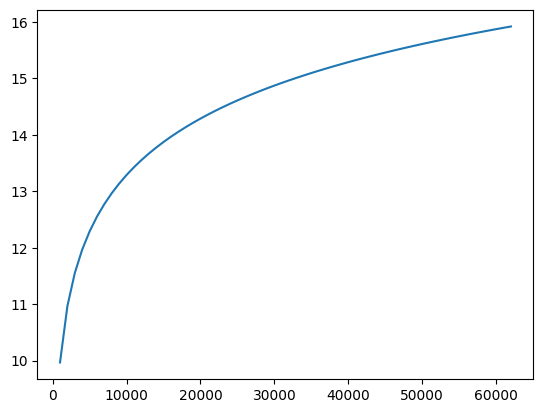

Entropy Plot for seed length 8 and sequence length 100000


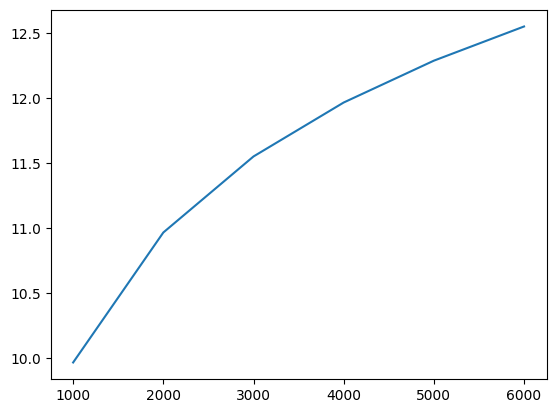

Entropy Plot for seed length 8 and sequence length 300000


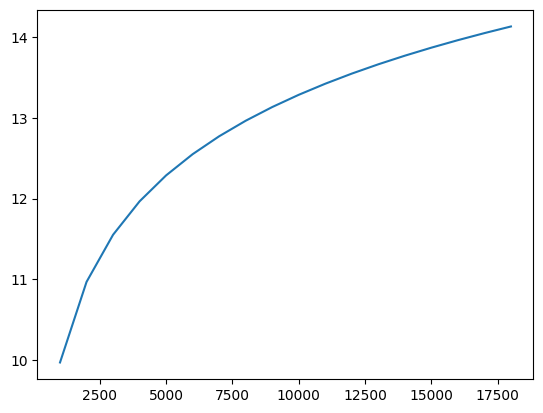

Entropy Plot for seed length 8 and sequence length 1000000


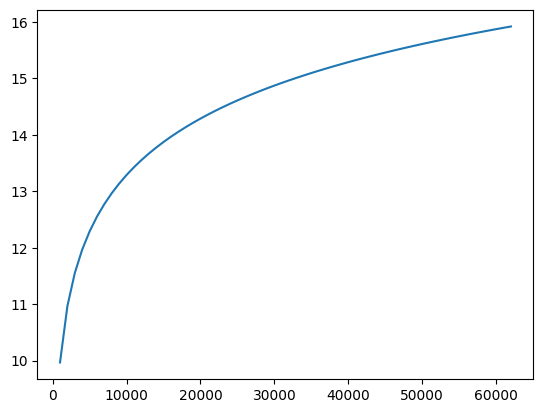

In [12]:

for (seed_len, seq_len_sequences) in ALL_SEQUENCES.items():
    for (seq_len, sequence) in seq_len_sequences.items():
        print(f"Entropy Plot for seed length {seed_len} and sequence length {seq_len}")
        plot_entropy(sequence, INCREMENT, use_shannon=True)


Autocorrelation plot for seed length 1 and sequence length 100000


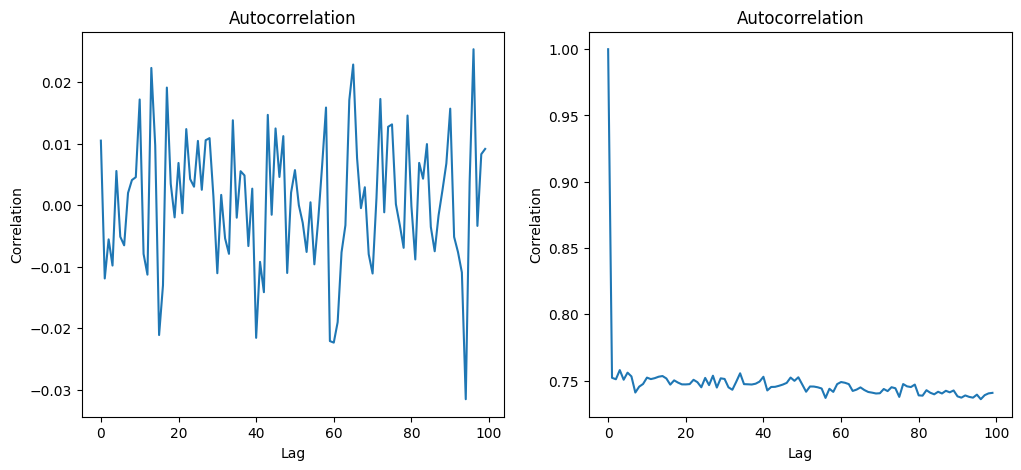

Autocorrelation plot for seed length 1 and sequence length 300000


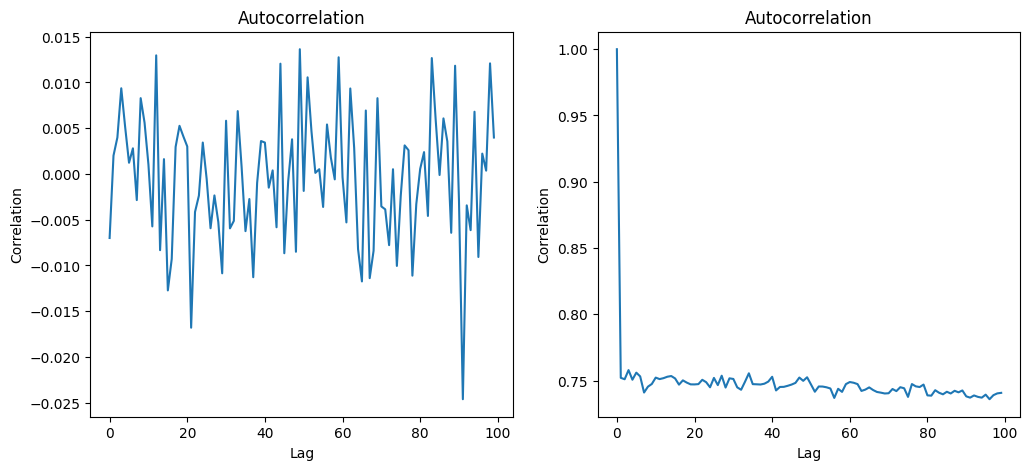

Autocorrelation plot for seed length 1 and sequence length 1000000


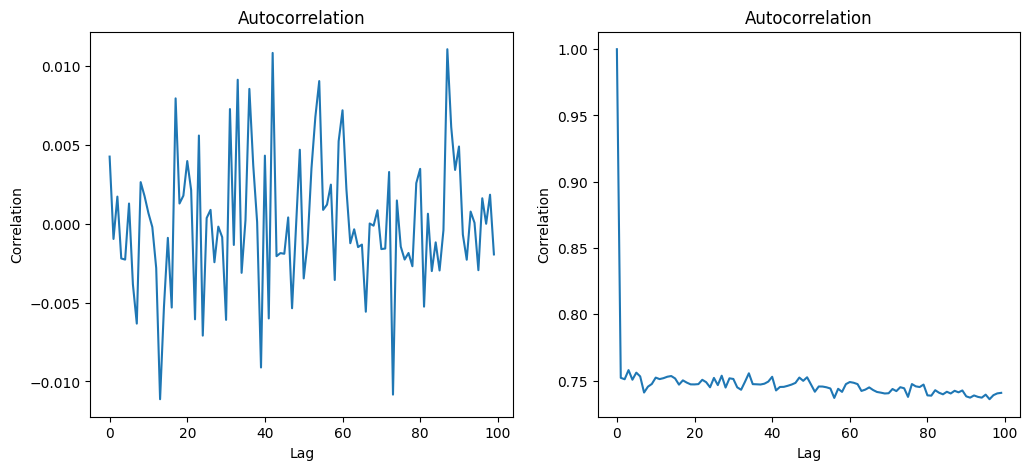

Autocorrelation plot for seed length 2 and sequence length 100000


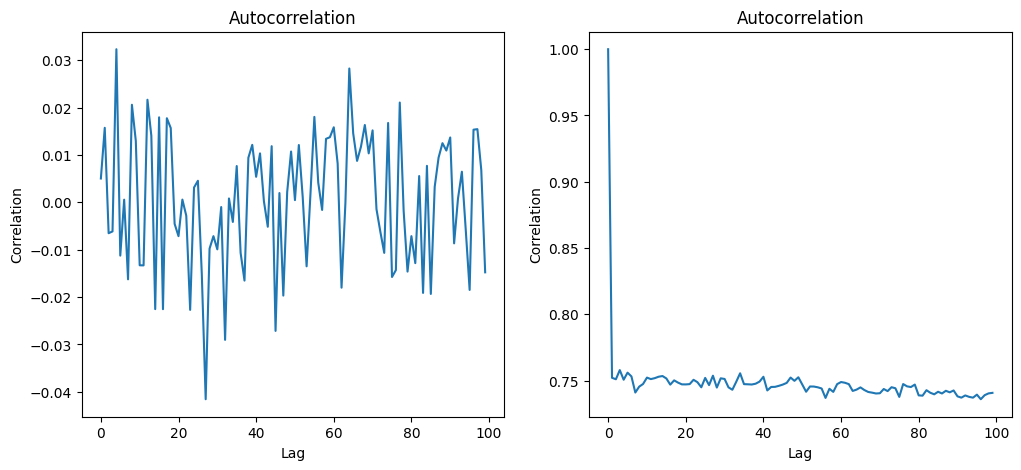

Autocorrelation plot for seed length 2 and sequence length 300000


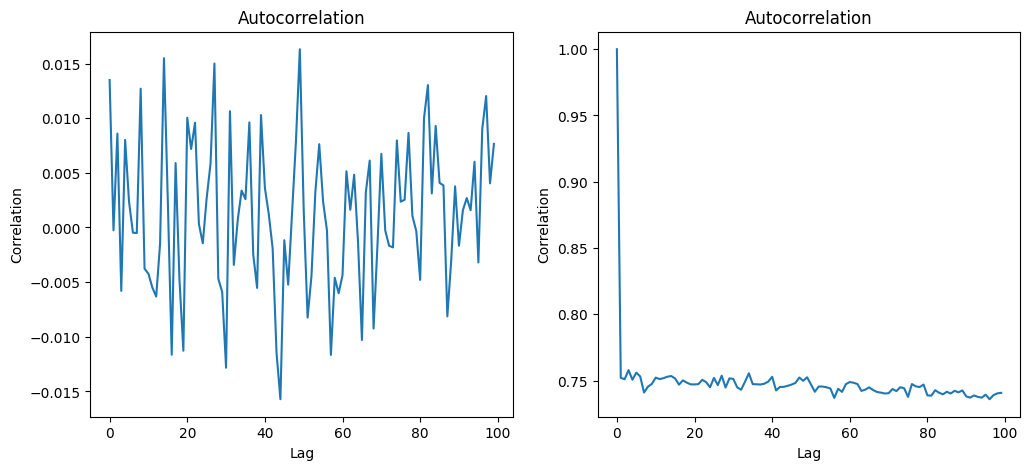

Autocorrelation plot for seed length 2 and sequence length 1000000


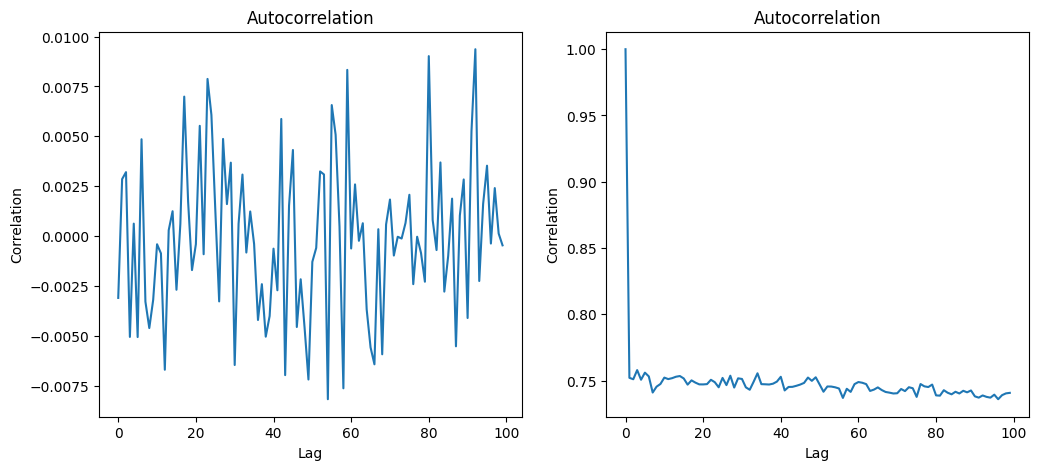

Autocorrelation plot for seed length 8 and sequence length 100000


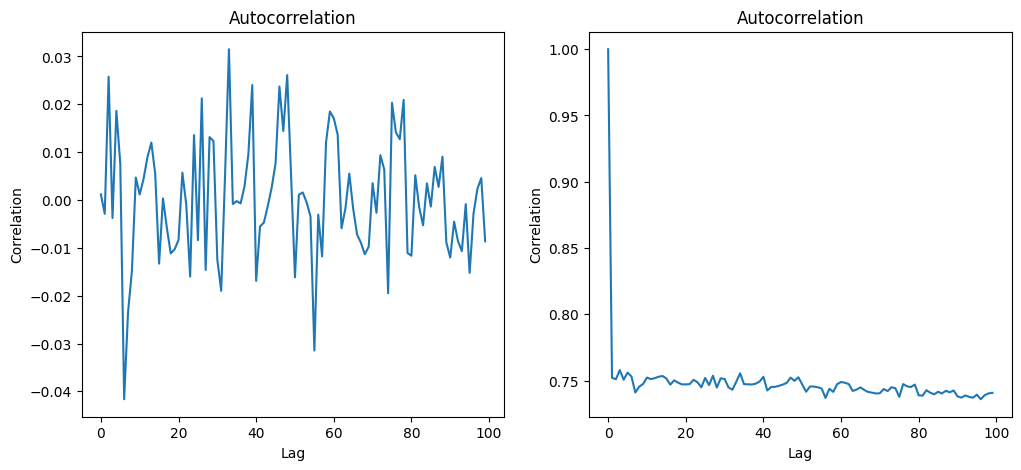

Autocorrelation plot for seed length 8 and sequence length 300000


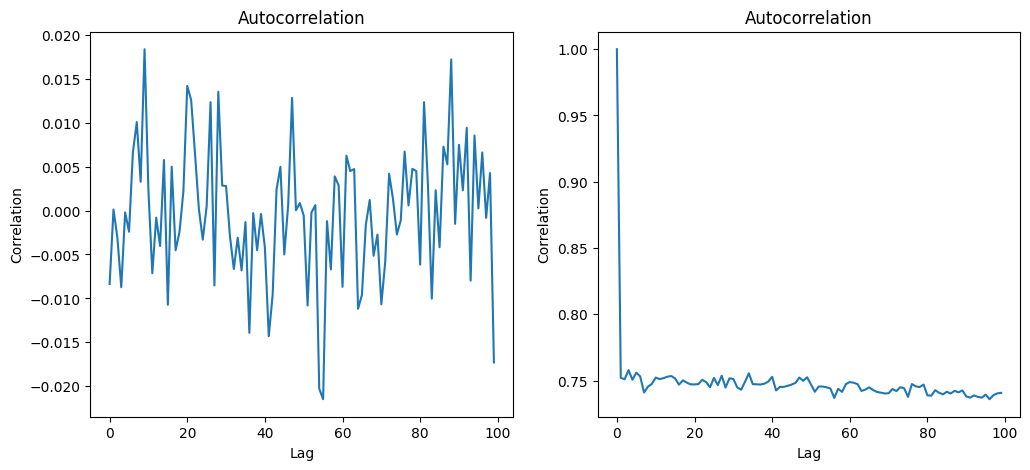

Autocorrelation plot for seed length 8 and sequence length 1000000


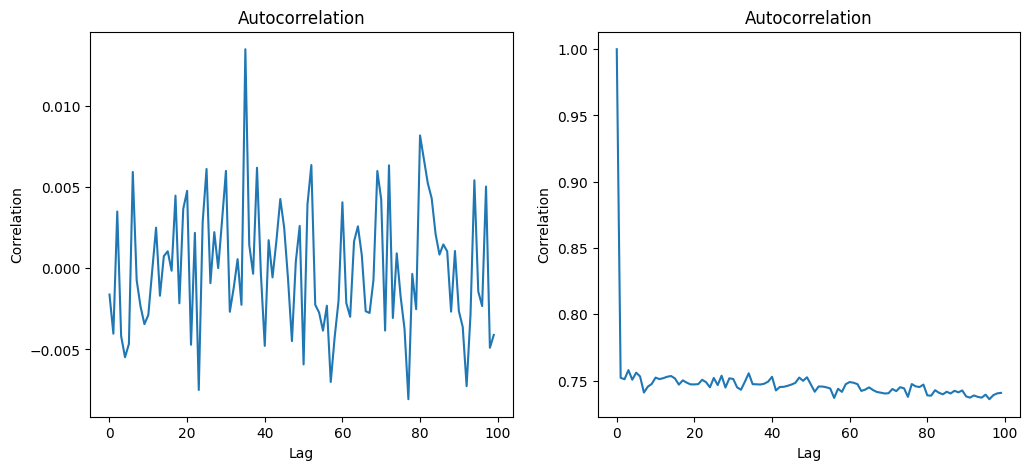

In [21]:
def get_autocorrelation(sequence:np.ndarray, lag):
    """
    Returns the autocorrelation for the given sequence and lag. This is the
    covariance between the sequence and the sequence shifted by lag, with
    respect to the variance of the sequence.
    """
    sequence_avg = np.average(sequence)
    length = len(sequence)
    return (np.dot(sequence[:length-lag] - sequence_avg, sequence[lag:] - sequence_avg)
            / (np.var(sequence) * len(sequence)))


def plot_autocorrelation(sequence, max_lag=100):
    """
    Computes the autocorrelation for the given sequence using lag values from 1
    to max_lag (inclusive) and plots them.

    We plot both autocorrelation based on the formula provided and the plot used
    in Task 2.
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    autocorr_array = np.array([get_autocorrelation(sequence, i) for i in range(1, max_lag+1)])
    plt.title('Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.plot(autocorr_array)

    plt.subplot(1, 2, 2)
    sequence = ALL_SEQUENCES[8][10**5]
    autocorr = np.correlate(sequence, sequence, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr = autocorr / autocorr[0]
    plt.plot(autocorr[:100])
    plt.title('Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')

    plt.show()


for (seed_len, seq_len_sequences) in ALL_SEQUENCES.items():
    for (seq_len, sequence) in seq_len_sequences.items():
        print(f"Autocorrelation plot for seed length {seed_len} and sequence length {seq_len}")
        plot_autocorrelation(sequence)

In [23]:
def run_ks_test(sequence: np.ndarray, theoretical_max: float) -> float:
    """
    Runs the Kolmogorov-Smirnov test on given sequence, which is expected
    to contain randomly generated values ranging from 0 to the given
    ``theoretical_max``.

    This test reports the maximum difference between the observed cumulative
    distribution function at any point and the expected CDF in a perfectly
    uniform distribution.
    """
    if theoretical_max <= np.max(sequence):
        raise ValueError("We have a value in the sequence exceeding "
                         "the theoretical maximum.")

    uniform_cdf = np.sort(sequence / theoretical_max)
    emperical_cdf = (np.arange(len(sequence)) + 1) / len(sequence)

    return np.max(np.abs(uniform_cdf - emperical_cdf))


for (seed_len, seq_len_sequences) in ALL_SEQUENCES.items():
    for (seq_len, sequence) in seq_len_sequences.items():
        print(f"K-S test result for seed length {seed_len} and sequence length "
              f"{seq_len:7d} is {run_ks_test(sequence, 1 << 128) * 100:.2f}%.")


K-S test result for seed length 1 and sequence length  100000 is 0.64%.
K-S test result for seed length 1 and sequence length  300000 is 0.45%.
K-S test result for seed length 1 and sequence length 1000000 is 0.51%.
K-S test result for seed length 2 and sequence length  100000 is 1.22%.
K-S test result for seed length 2 and sequence length  300000 is 0.69%.
K-S test result for seed length 2 and sequence length 1000000 is 0.40%.
K-S test result for seed length 8 and sequence length  100000 is 0.85%.
K-S test result for seed length 8 and sequence length  300000 is 0.55%.
K-S test result for seed length 8 and sequence length 1000000 is 0.28%.


### (BONUS) Part C: Breaking the Illusion of Randomness

### Bonus Task:
Train a light-weight model (small-neural net or decision tree) to predict the next number in your random number sequences generated from LCG and AES. Now try implementing at least one other more robust PRNGs from the list below:
- XOR-Shift Generator
- Permuted Congruential Generator (PCG) 
- SplitMix64 

In [73]:
# You may want to import these packages, though feel free to import anything else you need
import torch
import torch.nn as nn


class NextNumberPredictor(nn.Module):
    def __init__(self, layer_width, layer_depth):
        super(NextNumberPredictor, self).__init__()
        self.lstm = nn.LSTM(1, layer_width, layer_depth)
        self.fc = nn.Linear(layer_width, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

def train(model, data, num_epochs):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        for _input_sequence, _target in data:
            _input_sequence = torch.Tensor(_input_sequence).view(len(_input_sequence), -1)
            _target = torch.Tensor(_target).view(len(_target), -1)

            # Forward pass
            output = model(_input_sequence)
            loss = loss_fn(output, _target)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


for (sequence_type, sequence) in (("LCG", lcg_sequences[0]), ("AES", ALL_SEQUENCES[1][10**5])):
    for i in range(5):
        model = NextNumberPredictor(40, 1)

        data = [((num & (1 << i)) >> i) for num in sequence[:1000]]
        N_TRAIN = 700
        training_rngs = data[:N_TRAIN]
        test_rngs     = data[N_TRAIN:]

        data = [
            (training_rngs[:100], training_rngs[1:101]),
            (training_rngs[:200], training_rngs[1:201]),
            (training_rngs[:300], training_rngs[1:301]),
            (training_rngs[:400], training_rngs[1:401]),
            (training_rngs[:500], training_rngs[1:501]),
        ]

        # Train the model
        train(model, data, num_epochs=100)

        # Use the model to make predictions
        input_sequence = torch.Tensor(test_rngs[:100]).view(-1, 1)
        output = model(input_sequence)
        predicted_bits = ([0 if x < 0.5 else 1 for x in torch.flatten(output).tolist()])
        actual_bits    = (test_rngs[1:101])

        print(f"Predicting bit#{i} of the {sequence_type} sequence: "
              f"{sum(pred == actual for pred, actual in zip(predicted_bits, actual_bits))}% match.")


Predicting bit#0 of the LCG sequence: 99% match.
Predicting bit#1 of the LCG sequence: 100% match.
Predicting bit#2 of the LCG sequence: 88% match.
Predicting bit#3 of the LCG sequence: 83% match.
Predicting bit#4 of the LCG sequence: 73% match.
Predicting bit#0 of the AES sequence: 49% match.
Predicting bit#1 of the AES sequence: 51% match.
Predicting bit#2 of the AES sequence: 53% match.
Predicting bit#3 of the AES sequence: 53% match.
Predicting bit#4 of the AES sequence: 52% match.
